In [2]:
from ucimlrepo import fetch_ucirepo 
  
mushroom = fetch_ucirepo(id=73) 
  
X = mushroom.data.features 
y = mushroom.data.targets 

In [3]:
X.shape

(8124, 22)

In [4]:
X.isna().sum()

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

In [5]:
X["stalk-root"].groupby(X["stalk-root"]).count()

stalk-root
b    3776
c     556
e    1120
r     192
Name: stalk-root, dtype: int64

In [6]:
X_new = X.fillna("b")
# X_new["stalk-root"].groupby(X_new["stalk-root"]).count()
X_new  = X_new.drop("veil-type", axis=1)

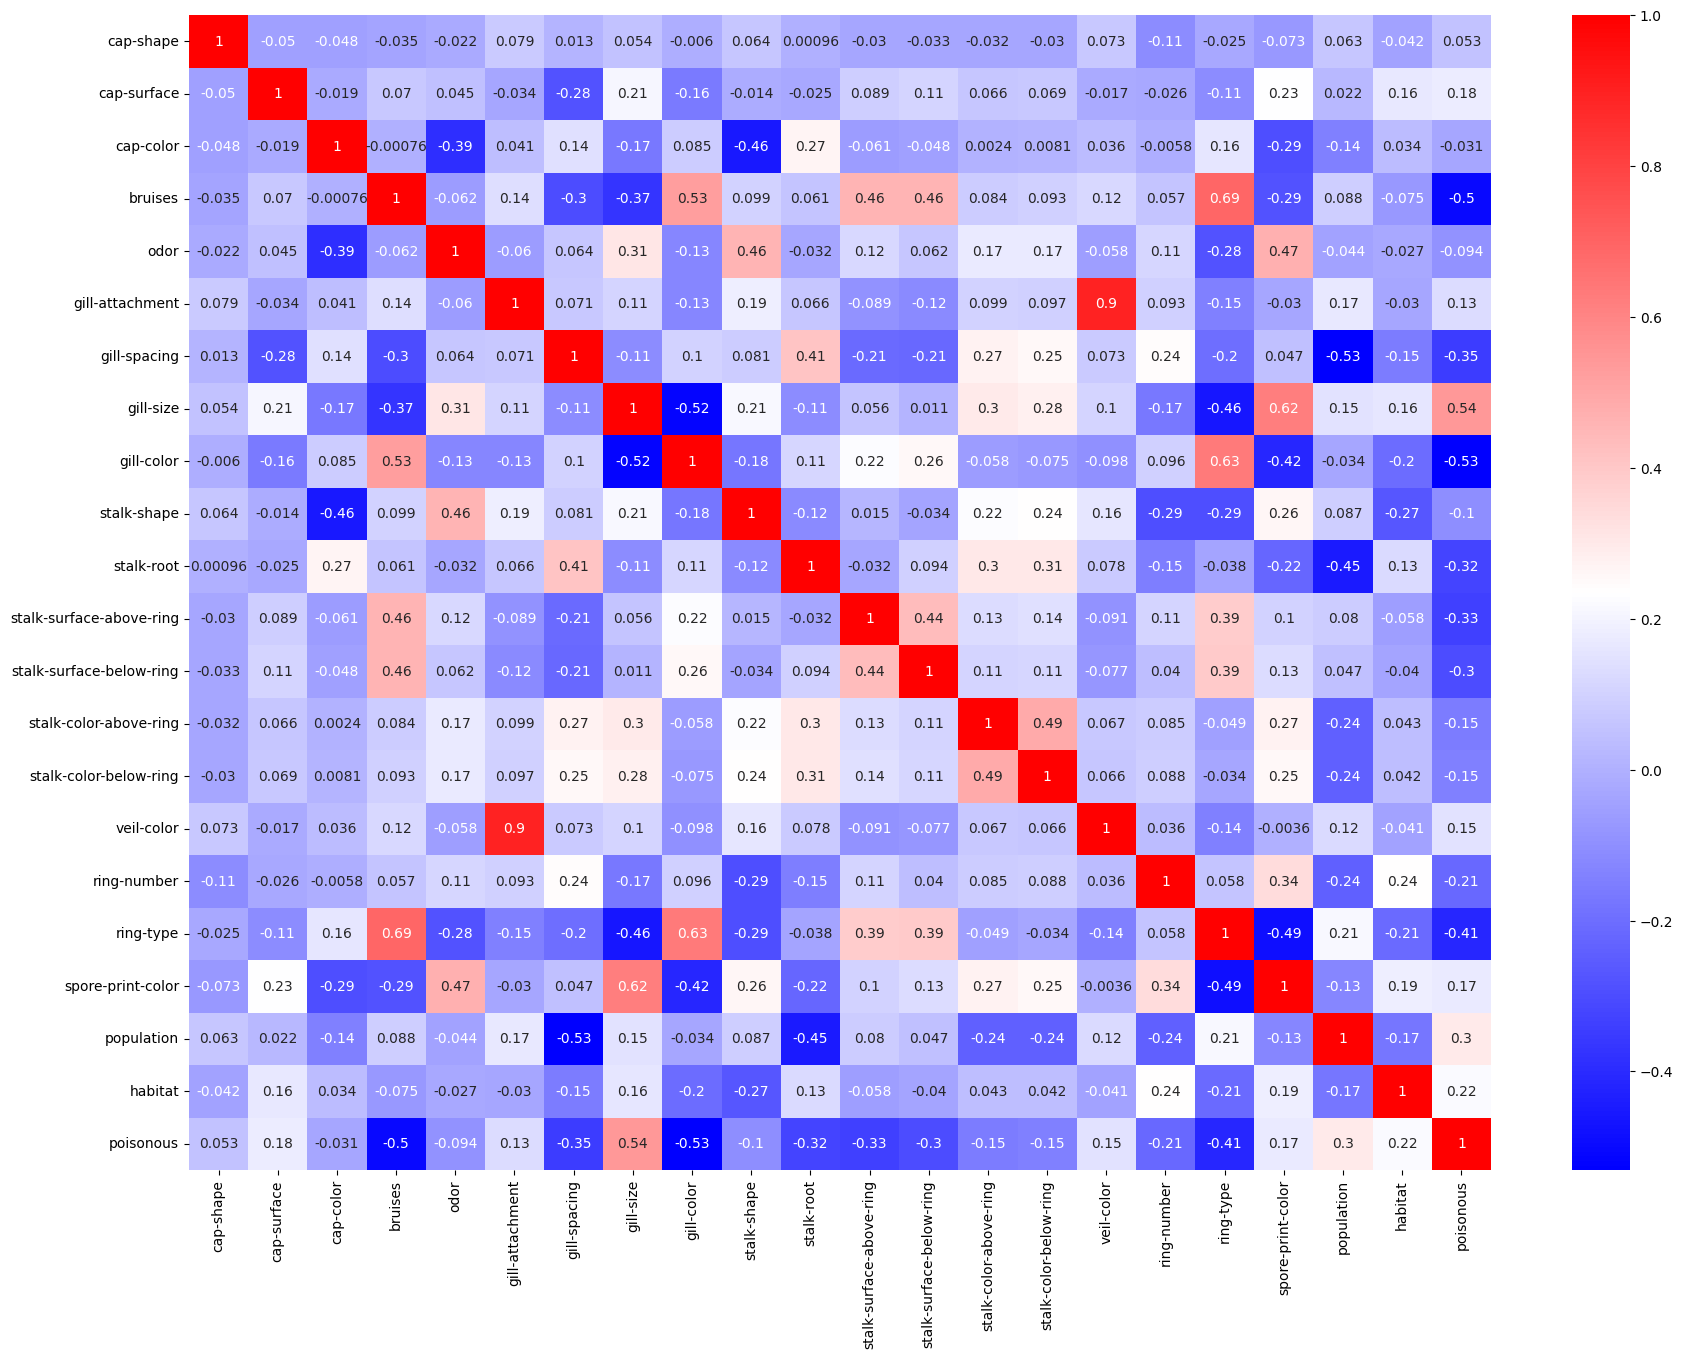

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df = pd.concat([X_new, y], axis=1)
label_encoder = LabelEncoder()
for col in df.columns:
    df[col] = label_encoder.fit_transform(df[col])
plt.figure(figsize=(21, 15))
sns.heatmap(df.corr(), annot=True, cmap='bwr')
plt.show()

In [165]:
import pandas as pd
from math import log2


def gain_ratio(data: pd.DataFrame, target: str, feature: str) -> float:
    start_entropy = calc_entropy(data[target])

    unique = data[feature].unique()
    data_len = len(data[target])
    sum_entropy = 0
    split_information = 0
    #print(len(unique), feature)
    for i in range(len(unique)):
        sub_data = data[data[feature] == unique[i]][target]
        weight = len(sub_data) / data_len
        #print("weight ", weight)
        sum_entropy += calc_entropy(sub_data) * weight
        split_information -= weight * log2(weight)

    information_gain = start_entropy - sum_entropy
    #print(information_gain, split_information)
    return information_gain / split_information


def calc_entropy(data: pd.Series) -> float:
    value_counts = data.value_counts()
    count = len(data)
    entropy = 0
    for elem in value_counts:
        freq = elem / count
        if freq > 0.0001:
            entropy -= freq * log2(freq)
    #print("entropy: ", entropy)
    return entropy

In [166]:
gain_ratio(df, "poisonous", "veil-color")

0.12136782986327081

In [238]:
gain = {}
for name in df:
    gr = gain_ratio(df, "poisonous", name)
    gain[name] = gr
gain = {k: v for k, v in sorted(gain.items(), key=lambda item: item[1])}
for key in gain.keys():
    print(key, gain[key], df[key].unique())

stalk-shape 0.007616338689021047 [0 1]
cap-color 0.01436144778069687 [4 9 8 3 2 5 0 7 1 6]
cap-surface 0.018146924511641294 [2 3 0 1]
cap-shape 0.02952206988590194 [5 0 4 2 3 1]
habitat 0.06894550944561556 [5 1 3 0 4 6 2]
gill-attachment 0.08181781181729314 [1 0]
ring-number 0.09140595216694188 [1 2 0]
stalk-root 0.10061433722325286 [2 1 0 3]
population 0.10080772885489377 [3 2 0 4 5 1]
veil-color 0.12136782986327081 [2 0 1 3]
stalk-color-below-ring 0.12204028298851576 [7 6 3 0 4 2 8 5 1]
stalk-color-above-ring 0.13106361757552204 [7 3 6 4 0 2 5 1 8]
gill-color 0.13759668648296527 [ 4  5  2  7 10  3  9  1  0  8 11  6]
gill-spacing 0.15815426132075966 [0 1]
stalk-surface-below-ring 0.1943304679865193 [2 0 3 1]
bruises 0.19644043129956856 [1 0]
ring-type 0.20716374427196207 [4 0 2 1 3]
spore-print-color 0.21818217753240354 [2 3 6 1 7 5 4 8 0]
stalk-surface-above-ring 0.23312407255673356 [2 0 1 3]
gill-size 0.25794648736352693 [1 0]
odor 0.3906481565033009 [6 0 3 5 2 1 8 7 4]
poisonous 1.

In [483]:
features = mushroom.data.features
target = mushroom.data.targets
selected_features = ["odor", "gill-size", "stalk-surface-above-ring"]
x = features[selected_features]

In [484]:
encoder = OneHotEncoder(drop="if_binary")
x_encoded = encoder.fit_transform(x).toarray()
y_encoded = encoder.fit_transform(target).toarray()

In [485]:
x_encoded.shape

(8124, 14)

In [486]:
import numpy as np


class PerceptronModel:
    def __init__(self, layers_sizes):
        self.layers = []
        self.layers_count = len(layers_sizes) - 1
        self.layers_sizes = layers_sizes
        for i in range(len(layers_sizes) - 1):
            self.layers.append(np.random.rand(layers_sizes[i + 1], layers_sizes[i] + 1) - 0.5)

        self.sums = []
        for i in range(1, len(self.layers_sizes)):
            self.sums.append(np.zeros((self.layers_sizes[i], 1)))

        self.layers_result = []
        for i in range(len(self.layers_sizes)):
            self.layers_result.append(np.zeros((self.layers_sizes[i], 1)))

        self.errors = []
        for i in range(1, len(self.layers_sizes)):
            self.errors.append(np.zeros((self.layers_sizes[i], 1)))

    def fit(self, X_test_data_frame, y_test_data_frame, a):
        X_test = np.array(X_test_data_frame)
        y_test = np.array(y_test_data_frame)

        err = 100000
        while err > 0 * len(y_test):
            err = 0
            layers_diff = [None] * self.layers_count
            for i in range(len(y_test)):
                result = self.forward_propagation(X_test[i])
                err += abs((y_test[i] - result)[0][0])
                self.errors[self.layers_count - 1] = np.array(y_test[i] - result)

                for i in range(self.layers_count - 2, -1, -1):
                    self.errors[i] = np.dot(self.layers[i + 1].T, self.errors[i + 1])
                    self.errors[i] = self.errors[i][0:len(self.errors[i]) - 1]

                for i in range(self.layers_count):
                    res = np.repeat(self.layers_result[i].T, self.layers[i].shape[0], axis=0)
                    self.sums[i][self.sums[i] >= 0] = 1
                    self.sums[i][self.sums[i] < 0] = 0
                    f_diff_sum = np.repeat(self.sums[i] * self.errors[i], self.layers[i].shape[1], axis=1)
                    if layers_diff[i] is None:
                        layers_diff[i] = (f_diff_sum * res) * a
                    else:
                        layers_diff[i] += (f_diff_sum * res) * a
                    # self.layers[i] = self.layers[i] + (f_diff_sum * res) * a

            for i in range(self.layers_count):
                self.layers[i] += layers_diff[i]
            
            print(err / len(y_test))

    def forward_propagation(self, input_vector):
        result = np.concatenate([input_vector, [1]])
        result = np.array(result)
        self.layers_result[0] = result.reshape((len(result), 1))
        for i in range(self.layers_count - 1):
            self.layers_result[i + 1] = np.dot(self.layers[i], self.layers_result[i])
            self.sums[i] = np.copy(self.layers_result[i + 1])
            self.layers_result[i + 1][self.layers_result[i + 1] < 0] = 0
            self.layers_result[i + 1] = np.expand_dims(np.concatenate([self.layers_result[i + 1].T[0], [1]]).T, axis=1)

        i = self.layers_count - 1
        self.layers_result[i + 1] = np.dot(self.layers[i], self.layers_result[i])
        self.sums[i] = np.copy(self.layers_result[i + 1])
        self.layers_result[i + 1][self.layers_result[i + 1] < 0] = 0
        return self.layers_result[i + 1]

    def predict(self, input_vectors):
        out = []
        for elem in np.array(input_vectors):
            result = np.concatenate([elem, [1]])
            for i in range(self.layers_count - 1):
                result = np.dot(self.layers[i], result)
                result[result < 0] = 0
                result = np.concatenate([result, [1]])

            result = np.dot(self.layers[self.layers_count - 1], result)[0]

            out.append(result)

        out = np.array(out).T
        out[out < 0] = 0
        return np.array(out).T


In [487]:
X_train, X_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.2, random_state=0)

In [498]:
perceptron = PerceptronModel([x_encoded.shape[1], 5, 1])

In [508]:
perceptron.fit(X_train, y_train, 0.00005)

0.3554764669560663
0.3394134176251756
0.32484213809532664
0.31309786419011315
0.3020259925580227
0.29124869962783057
0.28080165272263397
0.27075670545063724
0.2611753729838733
0.2521056299892311
0.24358021308210132
0.23561636324184035
0.2282167989432472
0.22137158103787627
0.21506049815272538
0.20925563371148692
0.20392384682496992
0.19902898529436083
0.19457015823924304
0.1904845354831568
0.18672776889034487
0.1832657504403343
0.18006694088256398
0.17710258117309555
0.17434673812844464
0.17177623340933795
0.16937049574672805
0.167111367348408
0.16498288745762416
0.16297106940088724
0.16106368219361272
0.15925004375021887
0.15754199119564127
0.1560225175236487
0.15456575351293095
0.15316582309665708
0.1518228091253908
0.15052859733710283


KeyboardInterrupt: 

In [522]:
y_predicted = perceptron.predict(X_test)

In [578]:
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(y_test)):
    if y_test[i] < 0.5 and y_predicted[i] < 0.5:
        TN += 1
    elif y_test[i] < 0.5 and y_predicted[i] > 0.5:
        FP += 1
    elif y_test[i] > 0.5 and y_predicted[i] > 0.5:
        TP += 1
    else:
        FN += 1

In [579]:
print(TP, FP, "\n", FN, TN)

729 16 
 44 836


In [580]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [581]:
accuracy

0.963076923076923

In [582]:
precision

0.978523489932886

In [583]:
recall

0.943078913324709

In [584]:
f = 2 * (precision * recall) / (precision + recall)

In [585]:
f

0.9604743083003953

In [586]:

answer = np.concatenate((y_predicted.reshape(1625, 1), y_test), axis=1)

In [599]:
answer = np.array(sorted(answer, key=lambda x: x[0])).T


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [601]:
x = [0]
y = [0]
for i in range(len(answer[0])):
    if answer[1][i] < 0.5:
        x.append(x[-1])
        y.append(y[-1] + 1)
    else:
        x.append(x[-1] + 1)
        y.append(y[-1])
    
    

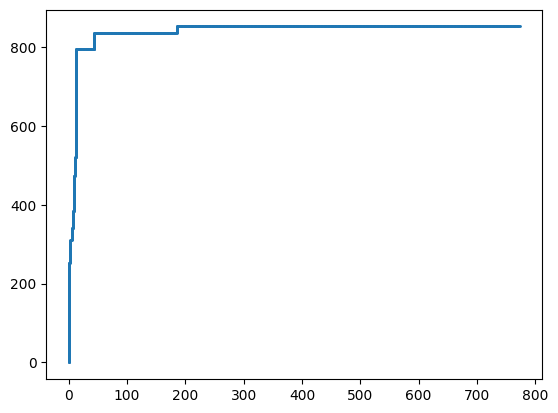

In [603]:
plt.plot(x, y, linewidth=0.2, marker='o', markersize=1)